In [42]:
from pandas import MultiIndex, Int16Dtype
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style('darkgrid')

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge,LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import joblib

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [4]:
%run "Funciones_Prepara_Prediccion.ipynb"

### Preparación datos

In [13]:
bicimad_def = _dataBaseOriginal("../../Data/DataFrame_Final_Cierre_Cluster.csv")

In [14]:
bicimad_def

,ESTACION,ANIO,MES,DIA,TEMPORADA,DIA_SEMANA,Es_Festivo,Es_FinSemana,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,DESC_TIEMPO
0,1,2018,1,1,INVIERNO,2,1,0,39,10.98,2.67,69.818182,7.080909,1030.727273,0.000000,0.000,Clouds
1,1,2018,1,2,INVIERNO,3,0,0,75,12.69,7.24,73.210526,5.420000,1031.842105,0.000000,0.000,Clouds
2,1,2018,1,3,INVIERNO,4,0,0,68,13.58,8.13,90.176471,4.794118,1031.588235,0.000000,0.000,Clouds
3,1,2018,1,4,INVIERNO,5,0,0,77,13.99,8.28,84.105263,5.334211,1025.789474,0.000000,0.000,Clouds
4,1,2018,1,5,INVIERNO,6,0,0,55,10.88,8.46,84.363636,5.445000,1012.045455,0.198636,0.075,Clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129326,175,2020,2,25,INVIERNO,3,0,0,87,17.48,5.91,54.769231,6.007692,1018.307692,0.000000,0.000,Clouds
129327,175,2020,2,26,INVIERNO,4,0,0,158,15.18,6.22,48.600000,5.321000,1020.500000,0.000000,0.000,Clear
129328,175,2020,2,27,INVIERNO,5,0,0,173,18.41,6.35,49.095238,6.207143,1020.619048,0.000000,0.000,Clear
129329,175,2020,2,28,INVIERNO,6,0,0,166,18.38,5.74,49.428571,2.174762,1019.571429,0.000000,0.000,Clear


In [15]:
#cat_cols= ['ANIO', 'MES', 'DIA_SEMANA', 'TEMPORADA','DESC_TIEMPO','AM_PM', 'Es_Festivo', 'Es_FinSemana']
cat_cols= ['MES', 'DIA_SEMANA', 'TEMPORADA', 'Es_Festivo', 'Es_FinSemana','DESC_TIEMPO']
#cat_cols= ['MES', 'DIA_SEMANA','Es_Festivo', 'Es_FinSemana']

num_cols= ['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION']

In [16]:
bicimad = bicimad_def

#bicimad = datos.drop(['CLUSTER_FullCols','TEMPORADA_NUM','CLUSTER_soloDemanda','CLUSTER_soloGeo','DIA','ANIO','DESC_TIEMPO_detalle'], axis=1)


bicimad['FECHA'] =pd.to_datetime({'year': bicimad['ANIO'],
                                          'month': bicimad["MES"]
                                          ,'day':  bicimad['DIA']
                                          },
                                          format='%d-%m-%Y', errors='coerce')

bicimad['MES']   = bicimad['MES'].astype('category')
bicimad['DIA_SEMANA'] = bicimad['DIA_SEMANA'].astype('category')
bicimad['Es_Festivo'] = bicimad['Es_Festivo'].astype('category')
bicimad['Es_FinSemana'] = bicimad['Es_FinSemana'].astype('category')
bicimad['DESC_TIEMPO'] = bicimad['DESC_TIEMPO'].astype('category')

bicimad = pd.get_dummies(bicimad, columns=cat_cols, drop_first=True)

X = bicimad[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h','PRECIPITACION_3h']]

scaler = StandardScaler()
bicimad[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h','PRECIPITACION_3h']] = scaler.fit_transform(X)

bicimad = bicimad.drop(['ANIO','DIA'], axis=1)

bicimad

,ESTACION,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,FECHA,...,TEMPORADA_VERANO,Es_Festivo_1,Es_FinSemana_1,DESC_TIEMPO_Clouds,DESC_TIEMPO_Drizzle,DESC_TIEMPO_Fog,DESC_TIEMPO_Mist,DESC_TIEMPO_Rain,DESC_TIEMPO_Snow,DESC_TIEMPO_Thunderstorm
0,1,39,-1.026930,-1.067735,0.725362,1.669834,1.987357,-0.250454,-0.203229,2018-01-01,...,0,1,0,1,0,0,0,0,0,0
1,1,75,-0.832167,-0.403777,0.907454,0.805625,2.143212,-0.250454,-0.203229,2018-01-02,...,0,0,0,1,0,0,0,0,0,0
2,1,68,-0.730798,-0.274473,1.818144,0.479964,2.107721,-0.250454,-0.203229,2018-01-03,...,0,0,0,1,0,0,0,0,0,0
3,1,77,-0.684101,-0.252680,1.492257,0.760986,1.297043,-0.250454,-0.203229,2018-01-04,...,0,0,0,1,0,0,0,0,0,0
4,1,55,-1.038320,-0.226529,1.506126,0.818633,-0.624397,1.093123,0.580350,2018-01-05,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129326,175,87,-0.286600,-0.597008,-0.082428,1.111414,0.251076,-0.250454,-0.203229,2020-02-25,...,0,0,0,1,0,0,0,0,0,0
129327,175,158,-0.548563,-0.551969,-0.413577,0.754113,0.557564,-0.250454,-0.203229,2020-02-26,...,0,0,0,0,0,0,0,0,0,0
129328,175,173,-0.180676,-0.533082,-0.386994,1.215193,0.574207,-0.250454,-0.203229,2020-02-27,...,0,0,0,0,0,0,0,0,0,0
129329,175,166,-0.184093,-0.621707,-0.369102,-0.882947,0.427748,-0.250454,-0.203229,2020-02-28,...,0,0,0,0,0,0,0,0,0,0


In [17]:
bicimad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129331 entries, 0 to 129330
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ESTACION                  129331 non-null  int64         
 1   DEMANDA                   129331 non-null  int64         
 2   TEMP_MAX                  129331 non-null  float64       
 3   TEMP_MIN                  129331 non-null  float64       
 4   HUMEDAD                   129331 non-null  float64       
 5   VIENTO                    129331 non-null  float64       
 6   PRESION                   129331 non-null  float64       
 7   PRECIPITACION_1h          129331 non-null  float64       
 8   PRECIPITACION_3h          129331 non-null  float64       
 9   FECHA                     129331 non-null  datetime64[ns]
 10  MES_2                     129331 non-null  uint8         
 11  MES_3                     129331 non-null  uint8         
 12  ME

In [19]:
# Estaciones = [145,58,148,157,163]

# Cluster 0 -> 145
# Cluster 1 -> 58
# Cluster 2 -> 148
# Cluster 3 -> 157
# Cluster 4 -> 163

df_EstacionesCluster = datos[['ESTACION', 'CLUSTER_soloDemanda']]
df_EstacionesCluster

,ESTACION,CLUSTER_soloDemanda
0,6,1
1,8,0
2,9,1
3,12,0
4,15,2
...,...,...
2117150,168,1
2117151,169,1
2117152,171,0
2117153,172,0


## Creación de DF de Train y Test

In [44]:
X_train_data = bicimad.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA"], axis=1)
y_train_data = bicimad.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')][['ESTACION', 'DEMANDA']]

In [46]:
y_train_data

,ESTACION,DEMANDA
0,1,39
1,1,75
2,1,68
3,1,77
4,1,55
...,...,...
129266,175,84
129267,175,63
129268,175,46
129269,175,65


## CLUSTER 0

In [47]:
estaciones = df_EstacionesCluster[df_EstacionesCluster['CLUSTER_soloDemanda']==0]['ESTACION'].unique()
estaciones

array([  8,  12,  20,  21,  25,  44,  47,  48,  50,  54,  63,  66,  67,
        69,  73,  77,  80,  81,  82,  92,  93,  96, 102, 106, 110, 113,
       123, 124, 125, 126, 130, 134, 145, 153, 154, 156, 167, 172,   7,
        14,  16,  18,  27,  51,  94, 142,   5, 121,   4, 116,  89, 115,
       171,  33,  99,  10], dtype=int64)

In [48]:
for estacion in estaciones:
    
    X_train = X_train_data[X_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)
    y_train = y_train_data[y_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)

    model = LGBMRegressor(random_state=seed,
                                         learning_rate = 0.1,
                                          num_leaves= 9,
                                          max_depth= 200,
                                          n_estimators= 70)

    resultado = model.fit(X_train, y_train)
    joblib.dump(resultado, '../Modelos/Modelo_'+str(estacion)+'.pkl', compress=9)

## CLUSTER 1

In [51]:
estaciones = df_EstacionesCluster[df_EstacionesCluster['CLUSTER_soloDemanda']==1]['ESTACION'].unique()
estaciones

array([  6,   9,  19,  31,  49,  56,  58,  59, 128, 135, 160, 161, 162,
       164, 168, 170,  13,  64,  83,  46, 169,   1,  38], dtype=int64)

In [53]:
for estacion in estaciones:
    
    X_train = X_train_data[X_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)
    y_train = y_train_data[y_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)

    model = LGBMRegressor(random_state=seed,
                                         learning_rate = 0.09,
                                          num_leaves= 5,
                                          max_depth= 100,
                                          n_estimators= 200)


    resultado = model.fit(X_train, y_train)
    joblib.dump(resultado, '../Modelos/Modelo_'+str(estacion)+'.pkl', compress=9)

## CLUSTER 2

In [60]:
estaciones = df_EstacionesCluster[df_EstacionesCluster['CLUSTER_soloDemanda']==2]['ESTACION'].unique()
estaciones

array([ 15,  36,  39,  40,  72,  85,  87,  98, 101, 104, 105, 107, 122,
       148, 150, 152, 158,  11,  34, 140, 141, 143, 147, 117, 137, 165,
       111, 146, 151, 112, 159,  60,  88,  97, 109, 120, 138, 127, 144,
       173, 174, 100,  35,   2,  32,  37, 119,  61,  29,  28], dtype=int64)

In [61]:
for estacion in estaciones:
    
    X_train = X_train_data[X_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)
    y_train = y_train_data[y_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)

    model = GradientBoostingRegressor(random_state=seed,
                                      learning_rate= 0.05, 
                                      max_depth= 100, 
                                      n_estimators= 200, 
                                      subsample= 0.4)


    resultado = model.fit(X_train, y_train)
    joblib.dump(resultado, '../Modelos/Modelo_'+str(estacion)+'.pkl', compress=9)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

## CLUSTER 3

In [95]:
estaciones = df_EstacionesCluster[df_EstacionesCluster['CLUSTER_soloDemanda']==3]['ESTACION'].unique()
estaciones

array([ 17,  26,  41,  45,  52,  53,  55,  65,  74,  75,  76,  78,  79,
        95, 103, 114, 131, 132, 133, 136, 139, 155, 157, 166,  71,  91,
       118,  42,  62,  86,  30, 108,   3,  84], dtype=int64)

In [96]:
for estacion in estaciones:
    
    X_train = X_train_data[X_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)
    y_train = y_train_data[y_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)

    model = GradientBoostingRegressor(random_state=seed,
                                      learning_rate= 0.02, 
                                      max_depth= 80, 
                                      n_estimators= 100, 
                                      subsample= 0.5)


    resultado = model.fit(X_train, y_train)
    joblib.dump(resultado, '../Modelos/Modelo_'+str(estacion)+'.pkl', compress=9)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## CLUSTER 4

In [97]:
estaciones = df_EstacionesCluster[df_EstacionesCluster['CLUSTER_soloDemanda']==4]['ESTACION'].unique()
estaciones

array([ 43,  57,  90, 129, 149, 163, 175], dtype=int64)

In [98]:
for estacion in estaciones:
    
    X_train = X_train_data[X_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)
    y_train = y_train_data[y_train_data['ESTACION'] == estacion].drop('ESTACION', axis=1)

    model = GradientBoostingRegressor(random_state=seed,
                                      learning_rate= 0.03, 
                                      max_depth= 300, 
                                      n_estimators= 900, 
                                      subsample= 0.06)


    resultado = model.fit(X_train, y_train)
    joblib.dump(resultado, '../Modelos/Modelo_'+str(estacion)+'.pkl', compress=9)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

## Testing

In [88]:
X_test = bicimad.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA"], axis=1)
y_test = bicimad.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')][['ESTACION','DEMANDA']]


In [89]:
y_test

,ESTACION,DEMANDA
651,1,1
652,1,3
653,1,1
654,1,2
655,1,2
...,...,...
129326,175,87
129327,175,158
129328,175,173
129329,175,166


In [90]:
X_test = X_test[X_test['ESTACION']==15].drop(columns='ESTACION')
y_test = y_test[y_test['ESTACION']==15].drop(columns='ESTACION')

In [91]:
model = joblib.load('../Modelos/Modelo_15.pkl')

0.4150420759154495


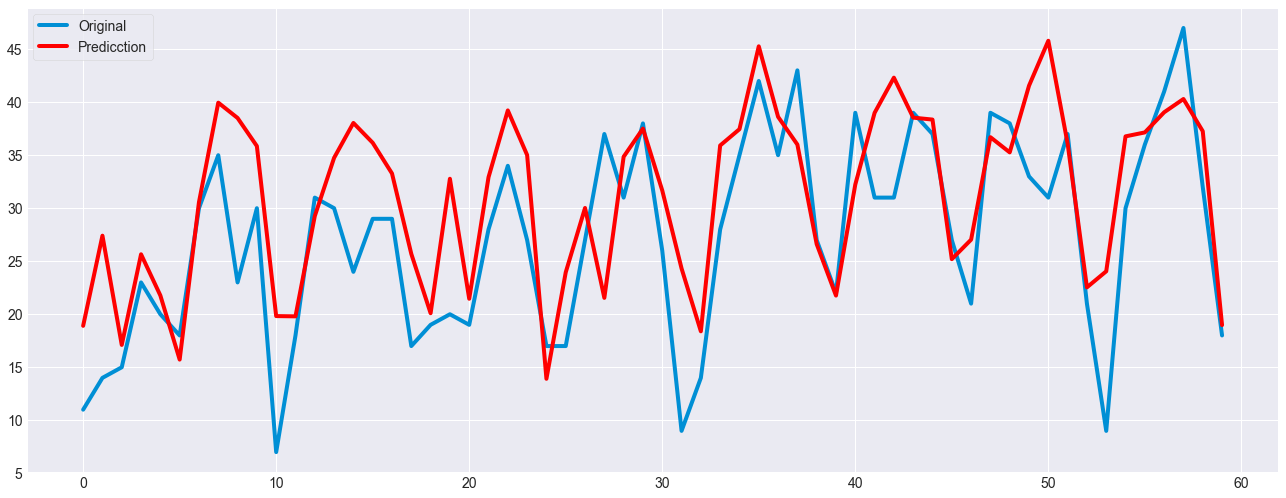

In [92]:
predictions = model.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()
